In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import subprocess
from pathlib import Path



"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [2]:
#data
BA_breweries = pd.read_csv('data/minimizedData/BA_breweries_small.csv')
RB_breweries = pd.read_csv('data/minimizedData/RB_breweries_small.csv')
BA_users = pd.read_csv('data/minimizedData/BA_users_small.csv')
RB_users = pd.read_csv('data/minimizedData/RB_users_small.csv')
BA_merged = pd.read_csv('data/minimizedData/BA_ratings_small_plus.csv')
RB_merged = pd.read_csv('data/minimizedData/RB_ratings_small_plus.csv')

#BA US data
BA_US_ratings = pd.read_csv('data/USData/BA_US_states_all.csv')

### Exploring Geographical Bias in Beer Ratings: Is your State swaying you Sip?

#### Introduction

Countries often claim that they have the “best” beer, in this article we are going to analyse the US and see if we can quantify a bias that people from different states have for each other's beers. Does the state you are from influence your beer preferences, especially towards beers coming from your own state? More generally, by examining the data from the Beer Advocate beer review website, we aim to uncover links between a user's geographical location, and how they rate beers. We were inspired by different regions of the world having similar food, so to try and find trends in beer data we’re going to start with a ‘regional’ analysis of states. Additionally, we will attempt to explain and find reasons for the bias in preference by looking at various factors, such comparing specifically neighbouring states, or analysing differences in beer style preferences. 

#### Data pipeline

To start, if you want to run the pipeline yourself, the given data needs to be in ‘data/baseData’. So the first thing we do is basic preprocessing, removing all the columns that we won’t need, and also importantly converting the .txt file into a .csv. We also compute some extra columns that we know are going to be useful, such as collecting location data from the breweries file and adding it to the beer file. This all goes into ‘data/minimizedData/’. We did some initial analyses with this data. Next, after we had decided to focus on the US only, we added to our pipeline to collect only US data from ‘minimizedData’, this US specific data goes into ‘data/USData/’. Finally we added another separate folder for our clustering algorithms, ‘data/knnData’, since we knew that we would need some additional features not present in ‘minimizedData’. The pipeline processes both the BeerAdvocate and RateBeer data, this was on purpose, so that we could test the 2 and see if there were any big differences, but there were not, and as we will explain just underneath we decided to focus solely on the Beer Advocate data.

#### The data we used

We had access to a large, high-quality dataset in the form different stats collected from the jus‘BeerAdvocate’ website as well as the ‘RateBeer’ website, but for our analyses, we found it largely sufficient to only use data from ‘BeerAdvocate’. Indeed we can see that the BeerAdvocate dataset has a higher percentage of US based users compared to users in the RateBeer dataset. Since we wanted to focus on a well defined geographical region, we thought it suitable to limit our data to US users as well as to the more US centered dataset; BeerAdvocate.


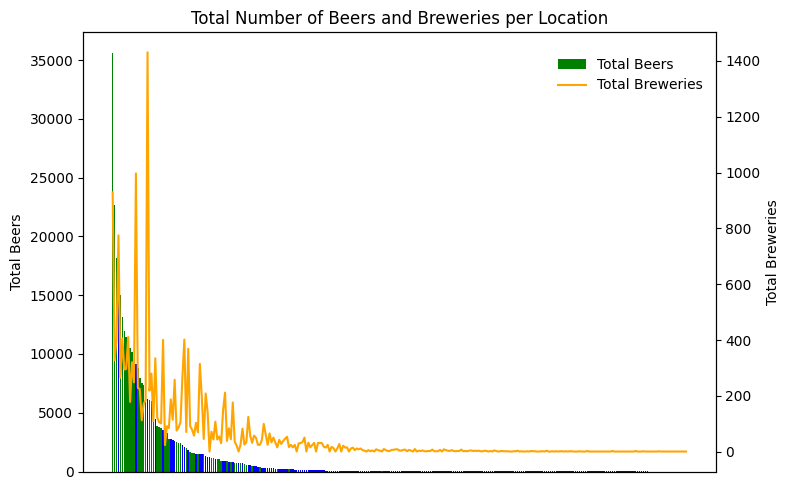

In [3]:
from src.choosingCountries.utils.beers_breweries import plot_beer_breweries_distribution

plot_beer_breweries_distribution(BA_breweries)

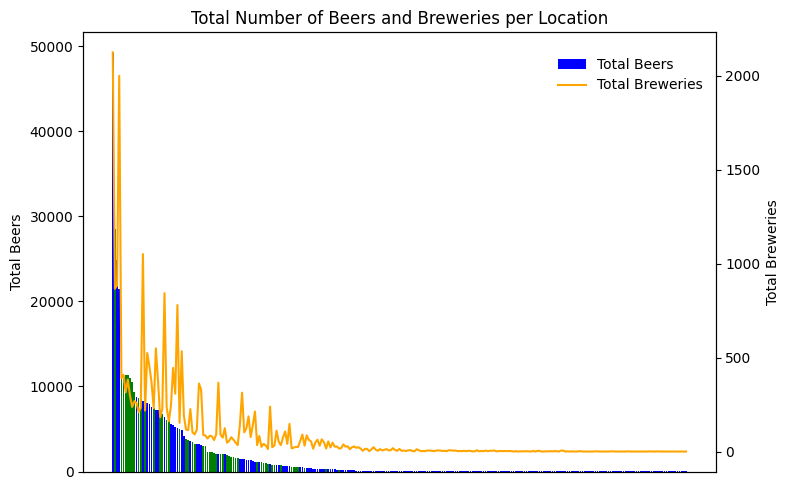

In [4]:
plot_beer_breweries_distribution(RB_breweries)

The top graphs is data from BeerAdvocate and the bottom from RateBeer. In the figures the green locations are US states and the blue represent all other countries, the orange line is breweries. Looking at BeerAdvocate, we can see that most of the locations selling high amounts of beers are based in the US. Brewery locations are offset for visibility. Since the majority of beers are being produced by the US, focusing only on the US won't be limiting the amount of data we have by that much. Additionally, looking at RateBeer, much less of the locations are US based, which justifies in part us not using RateBeer.

Number of users with known locations: 122425


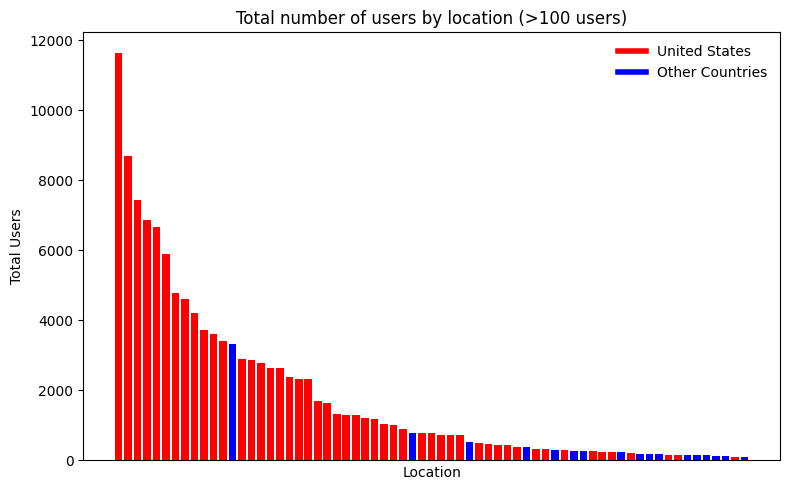

In [5]:
from src.choosingCountries.utils.users import plot_users

plot_users(BA_users)

Number of users with known locations: 50592


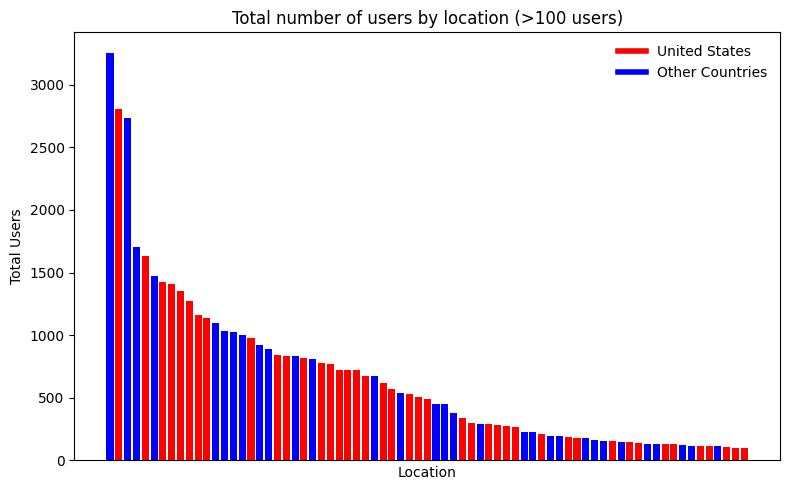

In [6]:
plot_users(RB_users)

The top plot is users from the BA dataset and the bottom from the RB dataset. The graphs show the distribution of users by location of origin (location must have more than 100 users). Again, in BA we see most of them are from the US, so focusing only on the US won't be limiting the amount of data we have too much, and again, RB shows many more non US users, further pointing us towards only using US BA data.

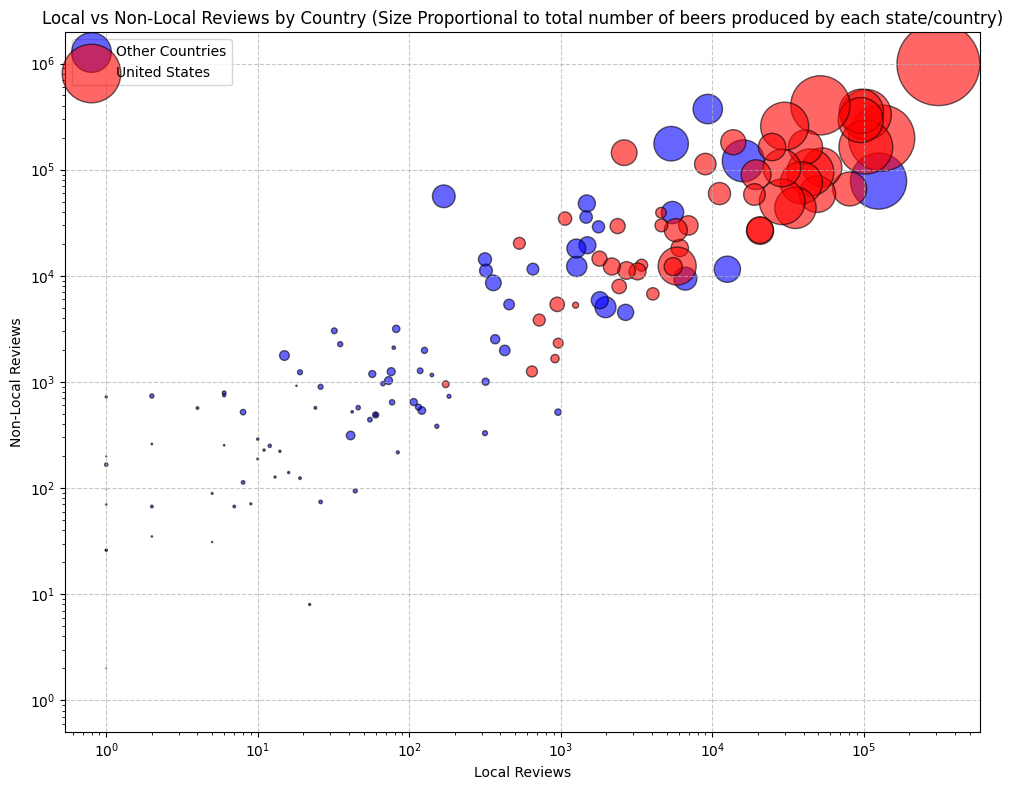

In [7]:
from src.choosingCountries.utils.reviews import plot_reviews

plot_reviews(BA_breweries, BA_merged)

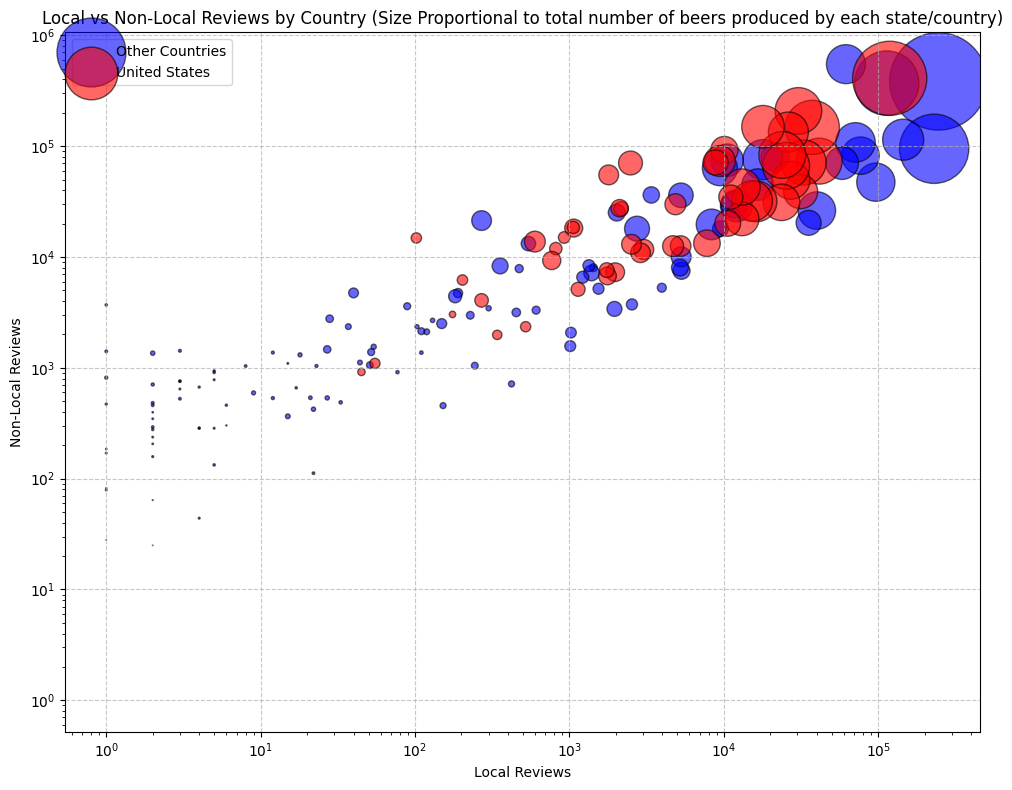

In [8]:
plot_reviews(RB_breweries, RB_merged)

The top plot is BA and the bottom RB. These graphs show the combined local/nonlocal reviews. Looking at the BA graph, the US dominates, with it being the most prevalent in the top right corner, on the contrary, looking at the RB graph, non US reviews are the majority in the top right corner.

In conclusion, we are choosing to restrict ourselves to the US so that we can make more meaningful interpretations, as there is already a lot of data, even for US only, and its easier to make more powerful conclusions on just the US rather than the whole world. Additionally, since BA contains a majority of US data, we feel that it's  more representative than RB, which has less US users. Thus we are choosing to focus solely on US based data from BA. We still have plenty of data points though (millions!), so we're not worried about not having enough data.

#### Q1) Regional analysis, do states in a region have similar taste in beer?

To visualise and understand the similarities between the beer ratings given by us states, we start by showing an interest in how neighbouring states rate their local beers. To do this, we grouped states by centering on each state and adding all its neighbouring states. This creates 50 separate regions, in which we calculate the similarities on those region’s beers (i.e. beers originating from the states in the corresponding group).

In [ ]:
from src.questions.question1.utils.basicPlots import plot_cohenD_some_states
from src.questions.question1.utils.q1prepData import q1prep_data
#for some reason i need to reimport neighbours_df every time i want to use it, i do not know why. oh well...
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
ratings_df = q1prep_data(BA_US_ratings, neighbours_df)
df = plot_cohenD_some_states(ratings_df, plot = True)

To have an indication of the similarity, We calculate Cohen's D for each pair-wise interaction in the region, so we're looking at the distribution of beer ratings for beers coming from that region and rated by users from that region. 
From this we obtain a lot of graphs. These can vary from having low cohen’s d values, indicating that the states in the region have 'similar' or at the very least not significantly (in the Cohen's D sense) different distributions of ratings. And other regions show states with a significant variation (cohen’s d > 0.2), meaning they are different. 
<br>
Here are 2 examples, one region with significance, and one without.


In [ ]:
from src.questions.question1.regionalAnalysis import regional_analysis
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
state_groups_df = regional_analysis(BA_US_ratings, neighbours_df)

      region  rating user_state rating_type
0  Wisconsin    4.04  Wisconsin    In-State
1  Wisconsin    4.00  Wisconsin    In-State


c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\question1\utils\basicPlots.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_cohen_df = pd.concat(all_cohen_results, ignore_index=True)


State Groups:
--------------------------------------------------
States: West Virginia, Ohio, Delaware, New York
--------------------------------------------------
States: Pennsylvania, Maryland, Virginia, Kentucky, New Jersey
--------------------------------------------------
States: South Dakota, Wyoming
--------------------------------------------------
States: Utah, Montana, Washington
--------------------------------------------------
States: Missouri, Iowa, Minnesota, New Mexico, Nevada, Idaho
--------------------------------------------------
States: Kansas, Nebraska
--------------------------------------------------
States: Texas, Oklahoma, Louisiana, Arizona, Oregon, Colorado, California
--------------------------------------------------
States: Illinois, Indiana
--------------------------------------------------
States: Wisconsin, Michigan, North Dakota
--------------------------------------------------
States: Alabama, Arkansas, South Carolina, Tennessee, Mississippi
-------

Next, we can try to build a map based on these regions, to see if there's a geographical component. To do this, we regroup states based on ascending absolute cohen’s d value. In order to have an as accurate as possible regrouping of the states, we group together the two states with the lowest cohen’s d and from there on, if the next lowest cohen’s d value is has either state already in a group, it adds the second state to that group, and if neither is in a group, we place the state pair in a new group. <br>
In the case of both states already being in a group and these being 2 separate groups, we do not make any changes, ensuring that each state is placed with the state it is the most similar to. <br>
This allows for a grouping of states based on a local their ratings of local beers, however states such as Alaska and Hawaii will not display at all as they do not have any neighbours with which to calculate the cohen’s d in their region. <br>
The grouping and subsequent mapping of these, results in certain groups being spread across the continental USA, why some are more clustered around a geographical area. (group 7 and group 9 respectively). <br>
This first visualisation and grouping does show limitations as it only bases on a part of the information given by a user's review and gives us initial custom regions that can be compared to in future parts.


Q2 Are regions biased when they rate each other?

c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\question2\utils\regions_cohenD.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




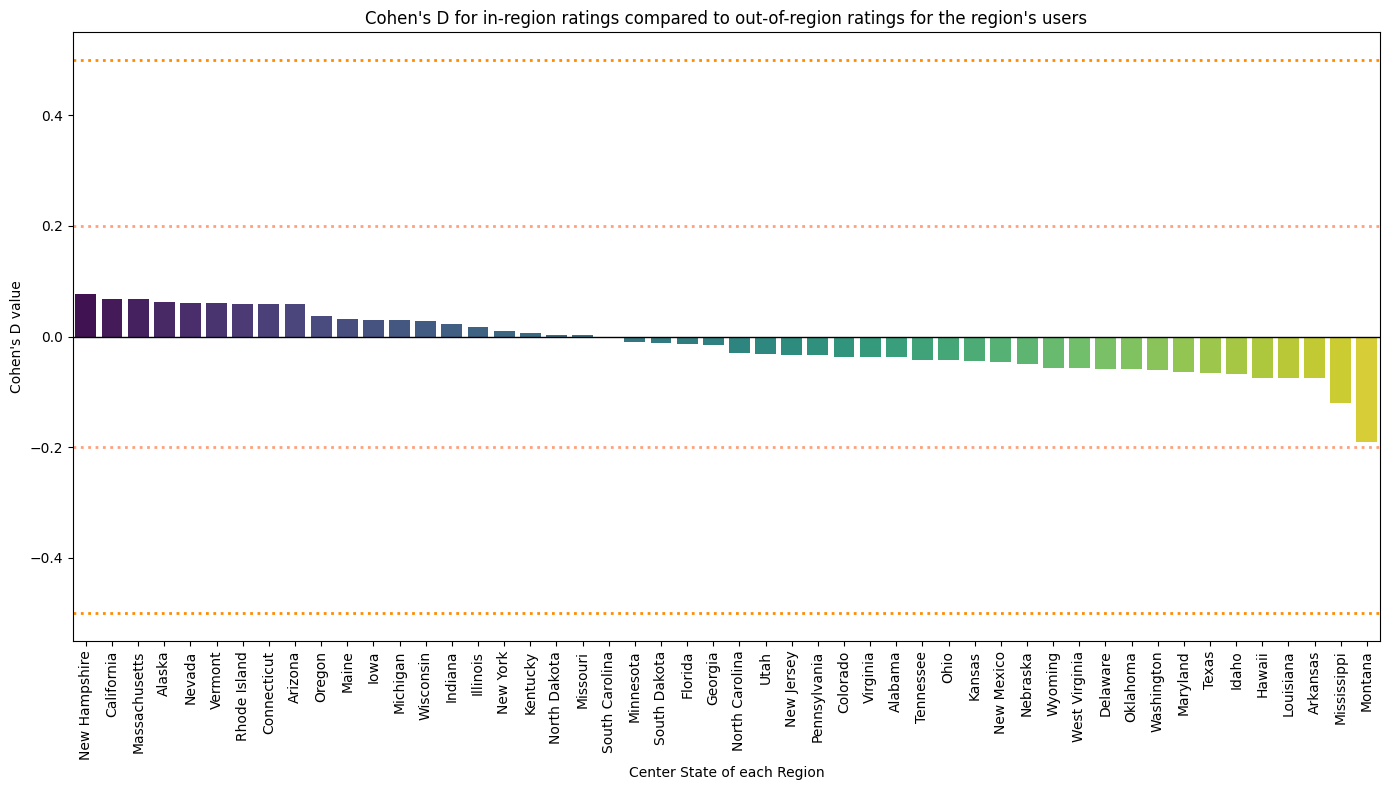

In [ ]:
from src.questions.question2.utils.regions_cohenD import regions_cohenD
neighbours_df = pd.read_csv('data/additionalData/bordering_states.csv', dtype={'state': 'string', 'neighbours': 'string'})
cohen_by_region_df = regions_cohenD(neighbours_df, BA_US_ratings)

When comparing regions to eachother, we don't really see many significant differences (Cohen's D > 0.2), there's maybe one region (Montana region) that could be different from the other regions. This is surprising! Instead of using our state and neighbours region to see differences, we can try to use the areas generated in question 1 and see if they are different. <br>
**Insert another graph** <br>
Unfortunately, these too are not significanlty different from eachother in terms of avg ratings.
So this motivates us to look at things on a state-by-state level, will there be differences there?

Q3: State Specific analysis of in state and out state reviews

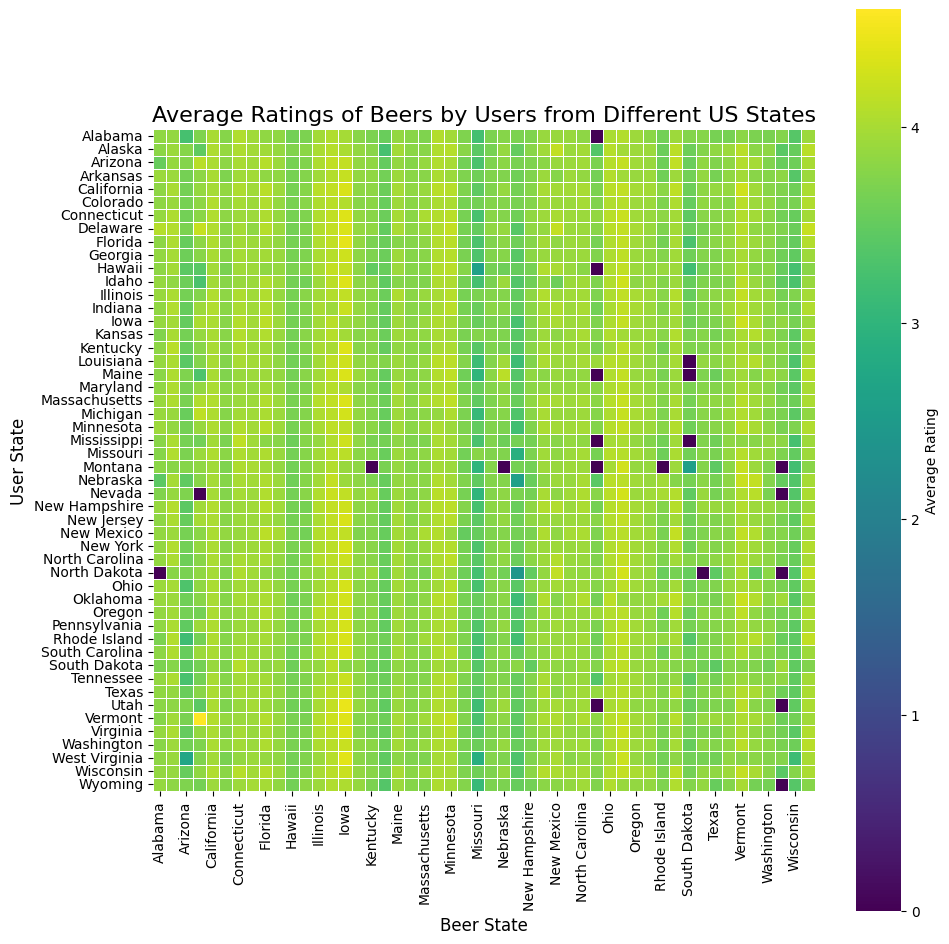

In [11]:
from src.choosingCountries.utils.heatmap import heatmap_avg_ratings
    
heatmap_avg_ratings(BA_US_ratings)

Here we see average ratings of beers coming from a specific state by users coming from a specific state. We were trying to see if any obvious patterns jumped out at us such as people from Alabama preferring beer from Alabama but it doesn't really seem so. All we can say is that beers coming from some states seem to be better rated than others, like Iowa, and beers coming from certain states are rated consistently lower, like Missouri. We replaced NaNs with 0's here, which is why we sometimes get these dark spots.

c:\Users\Enzo\Desktop\ada-2024-project-x0x0\src\questions\question3\utils\state_cohenD.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




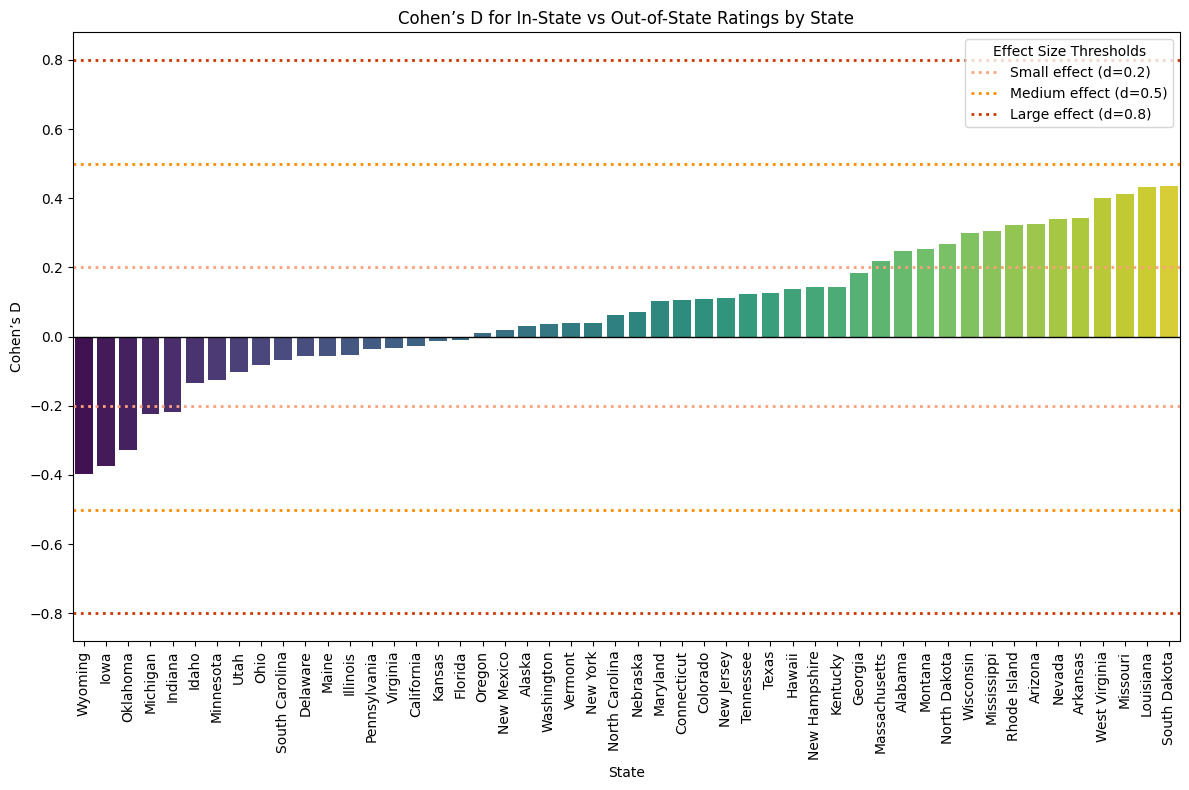

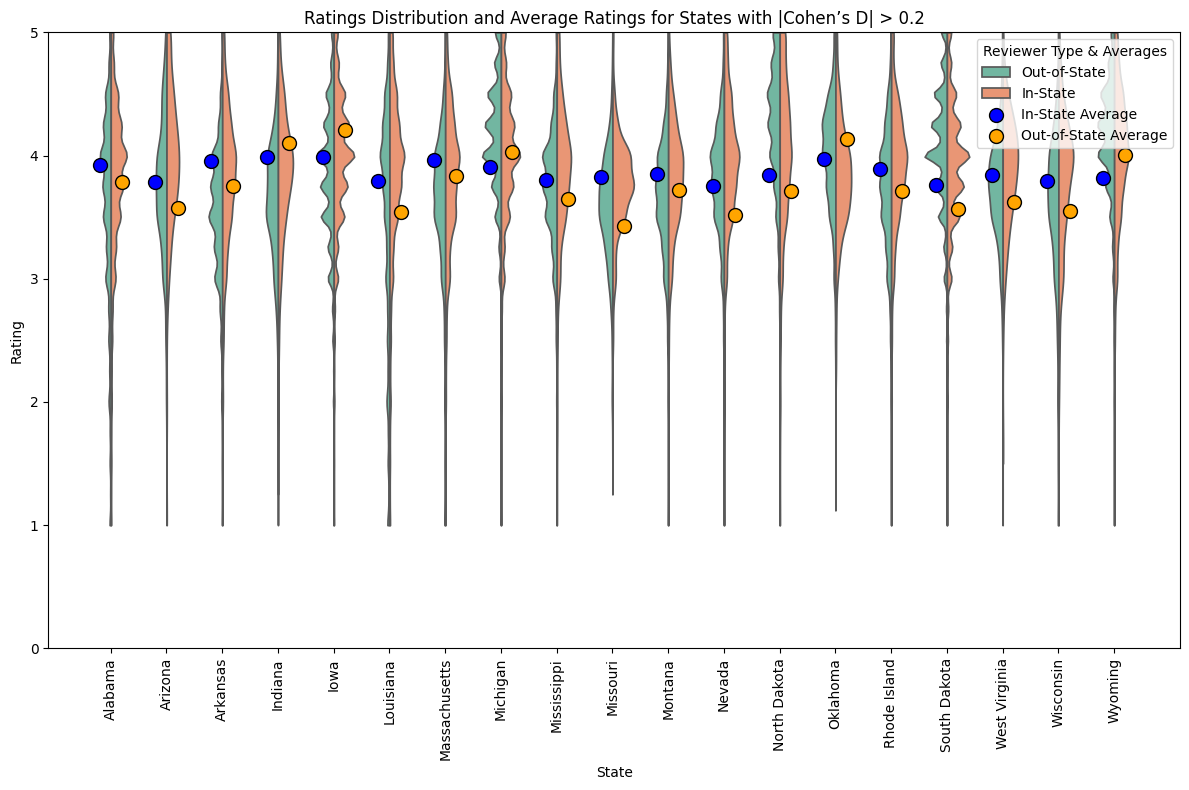

In [12]:
from src.questions.question3.stateBias import state_bias

state_bias(BA_US_ratings)



Trying to see if theres any big differences, it doesn't seem so. So we'll next test for significance.

We're using Cohen's D here since our sample sized is very big (in the milions!). Here we find that there are significant effect sizes for some of the states, cool!

Looking in detail at those significant states, we just wanted to get a general feel of what the distribution looked like.

Here we are plotting the difference in averages with the significance (Cohen's D) level.

Conclusion: There are significant differences between distribution of ratings, even on a state level!

For questions 4, we're still working on it, but we dont really have significant results...

For question 5, we have not started working on it yet.

Thanks for reading!